#Feature Engineering Notebook
Data given was in raw format and it needed to be converted into format which model could make sense. We considered data of 150K users while modelling. <br>
A data frame **final_df** was created with all the features.<br>
A dataframe **uninstall_unique** was created which had data of the users and  the latest uninstalled date. 

##Mount Google drive in Colab where data is stored 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
#os.chdir('drive/My Drive/Capstone/CleverTap Capstone/Data")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import necessary python libraries<br>
As the data was large we tried to use modin for faster computation but we found it was slower than pandas. 

In [0]:
#!pip install modin
#!pip install --upgrade pandas
#!pip install ray

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


##Function: inttostr()
All the six csv data files had date column and the dates were in integer format.This function converted and formatted the dates.

In [0]:
def inttostr(x):
  x = str(x)
  return x[:4]+'-'+x[4:6]+'-'+x[6:]

### Cell description
Below cell stores the number of times a user launched the app and the number of days between first launch and latest launch. Number of days were used to create additional feature **launch_rate**

In [11]:
launch = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/AppLaunched.csv')
launch['Date'] = pd.to_datetime(launch['Date'].apply(lambda x:inttostr(x)))
userids = launch.UserId.unique()[0:150000]
launch_days_list=[]
install_list=[]

for uid in tqdm(userids):
  temp = launch.loc[launch.UserId==uid]  
  
  launch_days_list.append((temp.Date.max()-temp.Date.min()).days)
  install_list.append(temp.shape[0])
  
  

'for uid in tqdm(userids):\n  temp = launch.loc[launch.UserId==uid]  \n  \n  launch_days_list.append((temp.Date.max()-temp.Date.min()).days)\n  install_list.append(temp.shape[0])'

### Cell Description
Below cell stores the latest status of user in the form completed, not completed or unknown.

In [33]:
registration = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/Registration.csv')
registration.Status=registration.Status.replace({'Complete':'Completed'})
status_list=[]
country_list = []


for uid in tqdm(userids):
  
  temp = registration.loc[registration.UserId==uid]
  status = temp.Status.tolist()[-1] if len(temp.Status.tolist())>0 else 'Unknown'
  status_list.append(status)
  if temp.shape[0]>0:
    country_list.append(temp.Country.value_counts().values[0])
    
  else:
    country_list.append(0)
    

100%|██████████| 25000/25000 [10:44<00:00, 38.76it/s]


In [0]:
#final_df = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/final_df.csv',index_col=0)


In [0]:
def top_country(x):
  if x>2:
    return 5
  else:return x
temp = pd.Series(country_list).apply(lambda x:top_country(x))

temp = temp.replace({0:'A',1:'B',2:'C',5:'MISC'})
country_list = temp.tolist()


In [37]:
temp.value_counts()

0    14267
1     9796
2      652
5      285
dtype: int64

In [0]:
final_df = pd.get_dummies(final_df)
final_df.to_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/final_df.csv')

### Cell Description
Below cell stores the number of times a user clicked UTM.

In [39]:
utmvisited = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/UTMVisited.csv')
utm_list = []
for uid in tqdm(userids):
  temp = utmvisited.loc[utmvisited.UserId==uid]
  utm_list.append(temp.shape[0])
#utm_list = pd.Series(utm_list)
#utm_list.to_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/utm_visted.csv')

100%|██████████| 25000/25000 [16:39<00:00, 25.01it/s]


### Cell Description
Below cell stores number of videos a user watched genre wise, category wise and program_type_dict wise. <br>
It also stores number of days user was active and number of videos he watched repetitively. <br>
Number of days is used later to calculate number of videos a user watched per day.


In [0]:
vidstarted = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/VideoStarted.csv')
vidstarted['Date'] = pd.to_datetime(vidstarted['Date'].apply(lambda x:inttostr(x)))

genre_dict = {genre:np.zeros(len(userids)) for genre in vidstarted.Genre.unique()}
category_dict = {cat:np.zeros(len(userids)) for cat in vidstarted.Category.unique()}
program_type_dict = {ptype:np.zeros(len(userids)) for ptype in vidstarted.ProgramType.unique()}

vidstart_days_list=[]
watches_rep_vid_list = []

for idx,uid in enumerate(tqdm(userids)):
  temp = vidstarted.loc[vidstarted.UserId==uid]
  
  
  for genre in temp.Genre.tolist():genre_dict[genre][idx]+=1;
  for cat in temp.Category.tolist():category_dict[cat][idx]+=1;
  for ptype in temp.ProgramType.tolist():program_type_dict[ptype][idx]+=1;
    
  vidstart_days_list.append((temp.Date.max()-temp.Date.min()).days)
  
  if len(temp.VideoId.value_counts().values)>2:
    rvf = temp.VideoId.value_counts().values[0] + temp.VideoId.value_counts().values[1] #if temp.VideoId.value_counts().values[0]>1
  elif len(temp.VideoId.value_counts().values)==1:
      rvf = temp.VideoId.value_counts().values[0]
  else: rvf=0
  
  watches_rep_vid_list.append(rvf)
  
  

In [14]:
temp = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/VideoStarted.csv')
temp = temp[temp.UserId.isin(userids)]
temp.shape

(262068, 12)

###Cell Description
Below cell merges three dictionaries genre, category and program type into single dictionary. Keys of these dictionaries will be used as features in final dataframe.

In [0]:
movie_det_dict = {**genre_dict, **category_dict, **program_type_dict}

### Cell Description
Below cell stores the number of times a user has watched video details.

In [43]:
viddetails = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/VideoDetails.csv')
viddetails['Date'] = pd.to_datetime(viddetails['Date'].apply(lambda x:inttostr(x)))

temp = viddetails.loc[viddetails.UserId.isin(userids)]

cnt_series = temp.UserId.value_counts()
viewed_vid_cnt = [cnt_series.loc[uid] if uid in cnt_series.index else 0 for uid in tqdm(userids) ]

#viddet_days_list = [(viddetails.loc[viddetails.UserId.isin(list(uid))]['Date'].max()-viddetails.loc[viddetails.UserId.isin(list(uid))]['Date'].max()).days for uid in tqdm(userids)]

100%|██████████| 25000/25000 [00:00<00:00, 71258.02it/s]


### Cell Description
Below cell creates empty data frame **final_df** and stores all the features generated till now in the dataframe.

In [44]:
final_df = pd.DataFrame(data=movie_det_dict)

final_df['launched_days'] = pd.Series(launch_days_list)
final_df['installed_times'] = pd.Series(install_list)
final_df['reg_status'] = pd.Series(status_list)
final_df['utm_visited_times'] = pd.Series(utm_list)
final_df['watched_days'] = pd.Series(vidstart_days_list)
final_df['vid_rep_count'] = pd.Series(watches_rep_vid_list)
final_df['viddet_view_cnt'] = pd.Series(viewed_vid_cnt)
final_df['country'] = pd.Series(country_list)
final_df.index = userids
final_df.head()

,Romance,Anime,Drama,Comedy,Martial Sports,Variety,Sports Magazine,Action,Tennis / Squash,TV Shows (General),...,TV Shows,Channels,launched_days,installed_times,reg_status,utm_visited_times,watched_days,vid_rep_count,viddet_view_cnt,country
449d354cfbe6c83b51b3bf98dc3f5722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,Unknown,1,NaN,0,0,A
5314fe615daa945fc2ae2bff5f46436d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,2,Unknown,1,NaN,0,0,A
8c28f540f91ff707a7b49c31b336f45f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,Unknown,1,NaN,0,0,A
865fc45c21a605c39f672d54d11430f7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,Completed,0,NaN,0,0,B
a49c4479e7242776bf4919d3fbc7fc12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15,4,Unknown,1,NaN,0,0,A


### Cell Description
Below cell creates dummy variables for all the categorical features.

In [45]:
final_df = pd.get_dummies(final_df);
final_df.shape

(25000, 70)

### Save the dataframe in csv file

In [0]:
final_df.to_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/final_df.csv')

### Cell Description
Below cell creates and stores a dataframe which contains latest entry when user uninstalled the app, leaving any previous uninstall records.


In [5]:
uninstall_unique = pd.DataFrame()
uninstall = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/AppUninstalled.csv')
uninstall['Date'] = pd.to_datetime(uninstall['Date'].apply(lambda x:inttostr(x)))

for uid in tqdm(userids):
  temp = uninstall.loc[uninstall.UserId==uid]
  temp = temp[temp.Date==temp.Date.max()]
  uninstall_unique = pd.concat([uninstall_unique,temp])

uninstall_unique.to_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/uninstall_unique.csv')


100%|██████████| 25000/25000 [12:40<00:00, 32.39it/s]


(0, 1000)

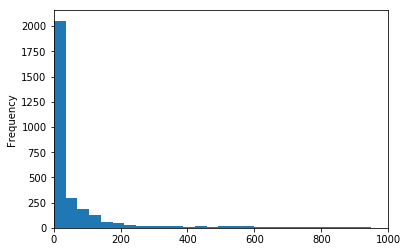

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
temp.VideoId.value_counts().plot(kind='hist',bins=2000)
plt.xlim(0,1000)